## Imports

In [159]:
%pylab inline
import numpy as np
from tqdm import *

Populating the interactive namespace from numpy and matplotlib


Initialization
-------------

Set up Hyperparameters
* InputSize
* OutputSize
* HiddenLayerWidth
* HiddenLayerHeight

In [8]:
class perceptron(object):
    def __init__(self, input_size, output_size, hl_neurons, hl_layers, learningrate):
        self.learningrate = learningrate
        self.input_size = input_size
        self.output_size = output_size
        self.hl_neurons = hl_neurons
        self.hl_layers = hl_layers
        
        # Now setup the weights in this format (inputs x neurons)
        self.weights = []
        self.ths = []
        self.weights.append(np.random.rand(hl_neurons, input_size))
        self.ths.append(np.random.rand(hl_neurons, 1))
        for i in xrange(1, hl_layers):
            self.weights.append(np.random.rand(hl_neurons, hl_neurons))
            self.ths.append(np.random.rand(hl_neurons, 1))
        self.weights.append(np.random.rand(output_size, hl_neurons))
        self.ths.append(np.random.rand(output_size, 1))
        self.delta_func = self.delta_func1
        self.sigmoid = numpy.vectorize(self.sigmoid)
        self.sigmoid_delta = numpy.vectorize(self.sigmoid_delta)
        
    def delta_func1(self, output, truths):
        return (output-truths)
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoid_delta(self, z):
        return (np.exp(-z))/((1+np.exp(-z))**2)
    
    def push_forward(self, inputs):
        A = []
        Z = []
        output = inputs
        for i in xrange(0, len(self.weights)):
            output = np.dot(self.weights[i], output) + self.ths[i]
            Z.append(output)
            output = self.sigmoid(output)
            A.append(output)
        return A, Z, output
    
    def feed_forward(self, inputs):
        _, _, output = self.push_forward(inputs)
        return output
    
    def multiply_and_average(self, delta, A):
        At = np.transpose(A)
        # Multiply the two, see if they're compatible (faster than throwing an exception)
        _ = np.dot(delta,At)
        ws = []
        for i in xrange(0, len(delta[0])):
            di = delta[:,[i]]
            Ai = At[[i],:]
            ws.append(np.dot(di, Ai))
        return np.mean(ws,axis=0)
    
    def train(self, inputs, truths):
        # First get the error and delta for output layer
        A, Z, output = self.push_forward(inputs)
#         curdelta = np.multiply((output - truths),self.sigmoid_delta(Z[len(Z)-1]))
        curdelta = np.multiply(self.delta_func(output, truths),self.sigmoid_delta(Z[len(Z)-1]))
        deltas = [curdelta]
        for i in reversed(xrange(0, len(self.weights)-1)):
            curdelta = np.multiply(np.dot(np.transpose(self.weights[i+1]), curdelta),
                                   self.sigmoid_delta(Z[i]))
            deltas.insert(0, curdelta)        
        A.insert(0,inputs)
        for i in reversed(xrange(0, len(self.weights))):
            self.weights[i] -= (self.learningrate * np.dot(deltas[i], A[i].T))
            tmp = np.mean(deltas[i],axis=1)
            tmp = np.matrix(tmp)
            tmp = tmp.T
            try:
                self.ths[i] -= (self.learningrate * tmp)
            except ValueError:
#                 print "tmp - %s" % tmp
#                 print "ths - %s" % self.ths[i]
                self.ths[i] -= (self.learningrate * tmp.T)
            
        return np.mean(abs(truths - output))

Testing Input (AND)
---------
Sample truth table for AND:

A | B | **Output**
--- | --- | ---
0 | 0 | 0
0 | 1 | 0
1 | 0 | 0
1 | 1 | 1

In [9]:
input_XOR = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_XOR = np.transpose(np.array([[0],[1],[1],[0]]))
input_AND = np.transpose(np.array([[0,0],[0,1],[1,0],[1,1]]))
gtruth_AND = np.transpose(np.array([[0],[0],[0],[1]]))

Final Results: [[ 0.12342281  0.65636643  0.65635293  0.66577607]]
Wall time: 271 ms


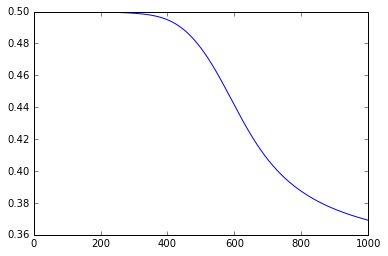

In [10]:
%%time
np.random.seed(1)
pp = perceptron(2, 1, 1, 1, 1.0)
results = []
for i in xrange(0, 1000): results.append(pp.train(input_XOR, gtruth_XOR))
plot(results)
print "Final Results: %s" % pp.feed_forward(input_XOR)

We can clearly see the training fail here, when we're training for XOR with only one neuron in the hidden layer, and the training fails. Let's try with two neurons:

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3571.43it/s]


Final Results = [[ 0.00700684  0.9878664   0.98749202  0.02203125]]
Wall time: 317 ms


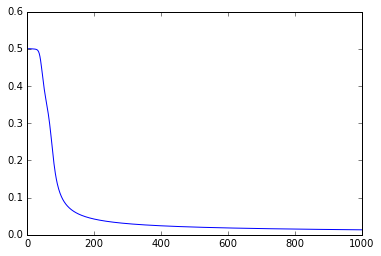

In [25]:
%%time
np.random.seed(1)
pp2 = perceptron(2, 1, 3, 1, 10)
plot([(pp2.train(input_XOR, gtruth_XOR)) for i in tqdm(xrange(0, 1000))])
print "Final Results = %s" % pp2.feed_forward(input_XOR)

The results look much better now.

Cross Entropy
------------

Now let us try modifying the cost function, see if we can't speed up computation a bit.
The ordinary cost derivative being used is:
$$\frac{dE}{dA} = (a-y)$$
Cross entropy uses the following function:
$$\frac{dE}{dA} = \frac{a-y}{a(1-a)}$$

In [57]:
def cross_delta(output, truths):
    return (output - truths)/(np.multiply(output,(1-output)))

Cross Entropy Final Results = [[  2.53993659e-05   9.99107935e-01   9.99106532e-01   1.29625199e-03]]
L2NORM        Final Results = [[ 0.00718332  0.97689461  0.97684651  0.02786687]]


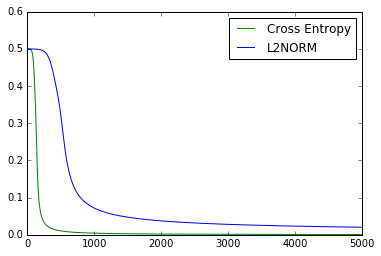

In [12]:
np.random.seed(2)
pp2 = perceptron(2, 1, 3, 1, 1)
np.random.seed(2)
pp3 = perceptron(2, 1, 3, 1, 1)
pp3.delta_func = cross_delta
plot([(pp3.train(input_XOR, gtruth_XOR)) for i in xrange(0, 5000)], "green",label = "Cross Entropy")
plot([(pp2.train(input_XOR, gtruth_XOR)) for i in xrange(0, 5000)], "blue", label = "L2NORM")
legend()
print "Cross Entropy Final Results = %s" % pp3.feed_forward(input_XOR)
print "L2NORM        Final Results = %s" % pp2.feed_forward(input_XOR)

We can clearly see the difference in training speed and training time.

Digit Classification
----

Now let's load some MNIST digits and attempt classification. We'll use the MNIST package to make loading from the compressed files easier.

In [13]:
from mnist import MNIST
mndata = MNIST('mnist')
data = mndata.load_training()

In [14]:
training_images = data[0]
training_labels = data[1]

Now we can attempt to create a neural net that can process the data. First thing is something to convert label data into useful ground truths for the perceptron, as well as some input processing to normalize input data.

In [187]:
def out_process(digit):
    outv = np.zeros(10)
    outv[digit] = 1
    return outv
def in_process(inval):
    return inval/255.0

In [188]:
np.random.seed(1)
mnist_pp = perceptron(len(training_images[0]), 10, 15, 2, 0.1)

In [189]:
## Reshape and fit training data
selection_max = 100
# selection_max = len(training_images)
def load_images(inp, selection_max):
    return in_process(np.matrix(inp[0:selection_max]).T)
training_data = load_images(training_images, selection_max)

In [190]:
## Reshape and fit labels
def load_labels(inp, selection_max):
    return numpy.apply_along_axis(func1d=out_process, arr=np.matrix(inp[0:selection_max]), axis=0)
training_data_l = load_labels(training_labels, selection_max)

In [191]:
## Check shapes
print training_data_l.shape
print training_data.shape

(10L, 100L)
(784L, 100L)


In [192]:
%%time
## Testing feed forward
y = mnist_pp.feed_forward(training_data)

Wall time: 11 ms


In [193]:
error = y - training_data_l
print y.shape
print training_data_l.shape
_, _, output = mnist_pp.push_forward(training_data)
print np.mean(abs(training_data_l - output))

(10L, 100L)
(10L, 100L)
0.899605478438


100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 47.11it/s]


Wall time: 22.4 s


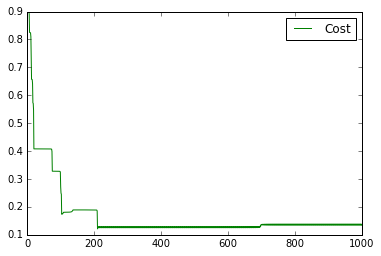

In [194]:
%%time
## Fingers crossed, try training
plot([(mnist_pp.train(training_data, training_data_l)) for i in tqdm(xrange(0, 1000))], "green",label = "Cost")
legend()

For the safety of time, let's start using cross entropy.

In [179]:
%%time
np.random.seed(1)
mnist_pp2 = perceptron(len(training_images[0]), 10, 15, 2, 0.1)
mnist_pp2.delta_func = cross_delta

Wall time: 0 ns


100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 37.31it/s]


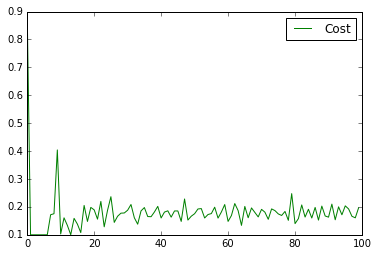

In [167]:
%%time
res = [float((mnist_pp2.train(training_data, training_data_l))) for i in tqdm(xrange(0, 100))]
plot(res, "green",label = "Cost")
legend()

Now, we need a framework for testing.

In [ ]:
testing = mndata.load_testing()

In [142]:
# Convert results to label outputs
def find_classification(inp):
    return np.argmax(inp)
def classify(inp):
    return np.apply_along_axis(find_classification, 0, inp)

In [168]:
selection_max = 50
testing_data = load_images(testing[0], selection_max)

In [169]:
out = mnist_pp2.feed_forward(testing_data)

In [172]:
classify(out)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4], dtype=int64)

Clearly, the sparse nature of the dataset is preventing any sort of useful training, even as the total cost is decreased.